# RBP motif clustering analysis

In [1]:
library(pheatmap)
library(dplyr)
library(ggplot2)
library(cluster)    # clustering algorithms
library(factoextra)
library(ggpubr)
set.seed(4)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



### Inputs

In [2]:
rbp_info_file<-"../input/cisbp_Homo_sapiens_2023_06/RBP_Information_all_motifs.txt"
energy_file <- "../output/mosbat/Homo_sapiens_2023_06.results.set1.energy.txt"

### Load data

In [3]:
energy <- data.table::fread(energy_file)
rpb_info<-data.table::fread(rbp_info_file,data.table = FALSE)

# Main

In [4]:
ecor<-cor(as.matrix(energy[,-1]))

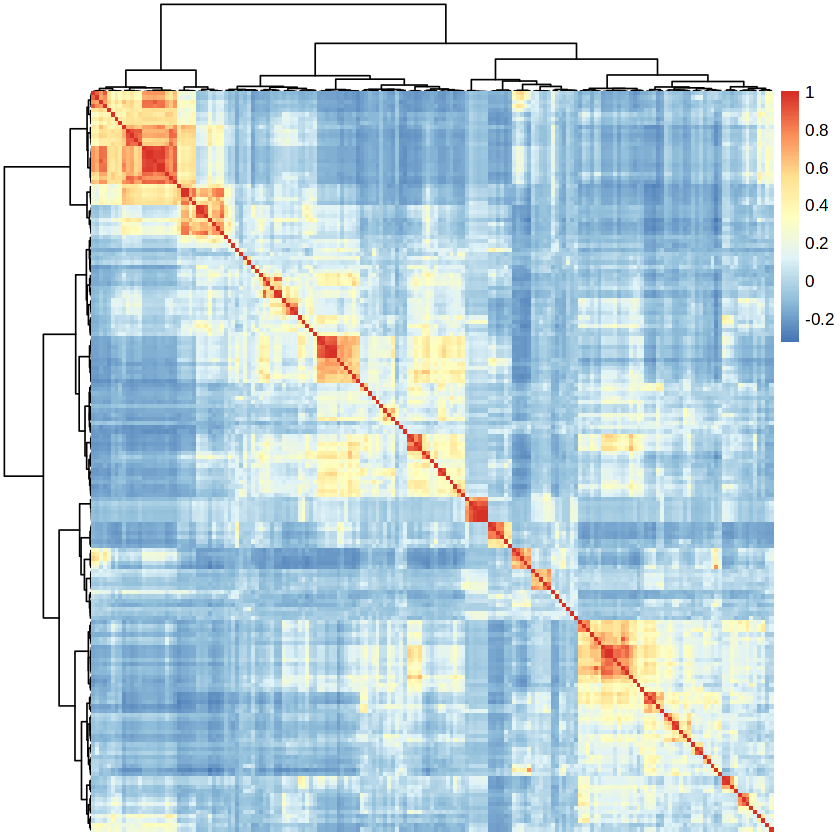

In [5]:
pheatmap(ecor,
         show_rownames = FALSE,
         show_colnames = FALSE,
         clustering_method = "ward.D",
         row_title="Motifs")

## Cluster motifs

In [6]:
df <- ecor
dim(df)

[1] 175 175

### Optimal number of clusters

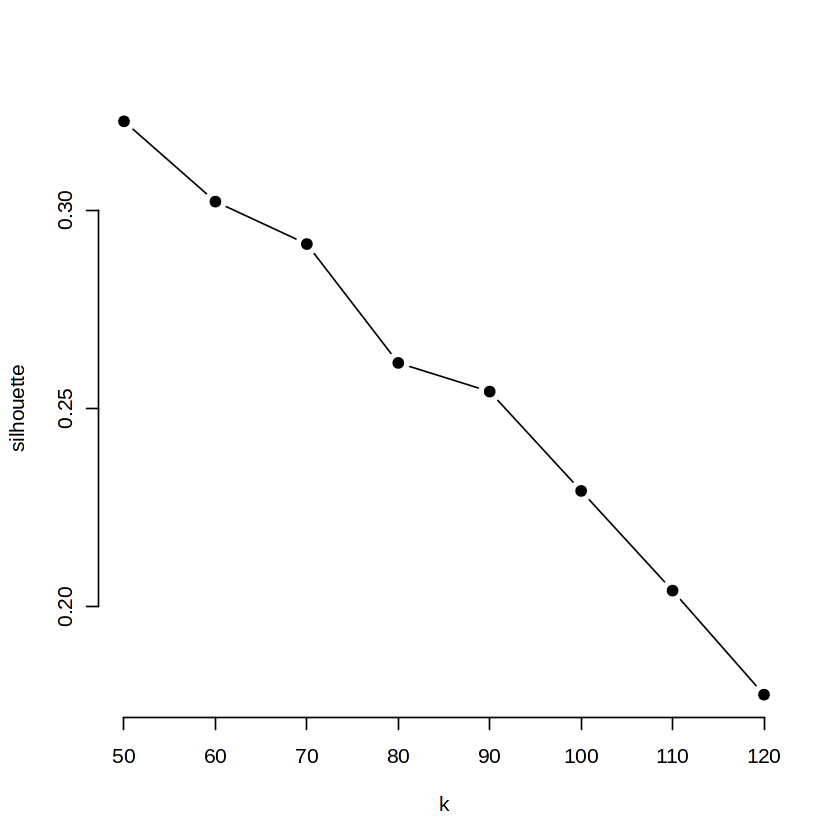

In [7]:
# function to compute average silhouette for k clusters
avg_sil <- function(k) {
  km.res <- kmeans(df, centers = k, nstart = 3)
  ss <- silhouette(km.res$cluster, dist(df))
  mean(ss[, 3])
}

# Compute and plot wss for k = 2 to k = 15
k.values <- c(seq(50,120,by = 10))

# extract avg silhouette for 2-15 clusters
avg_sil_values <- lapply(k.values, avg_sil)

plot(k.values, avg_sil_values,
       type = "b", pch = 19, frame = FALSE, 
       xlab = "k",
       ylab = "silhouette")

### Cluster motifs

In [8]:
set.seed(7)
clusts<-kmeans(df, centers = 70, nstart = 3)
centers<-apply(abs(clusts$centers),1,function(row){names(row)[row==max(row)][1]})

In [9]:
motif.clusters<-data.frame(motif=names(clusts$cluster),
                           cluster_num=clusts$cluster) %>%
                mutate(representative_motif=centers[cluster_num]) %>%
                arrange(cluster_num)

In [10]:
clust.info<-motif.clusters %>%
            rename("Motif_ID"="motif") %>%
            left_join(.,rpb_info %>% distinct(Motif_ID,RBP_Name,Family_Name))

Joining, by = "Motif_ID"


Joining, by = "representative_motif"


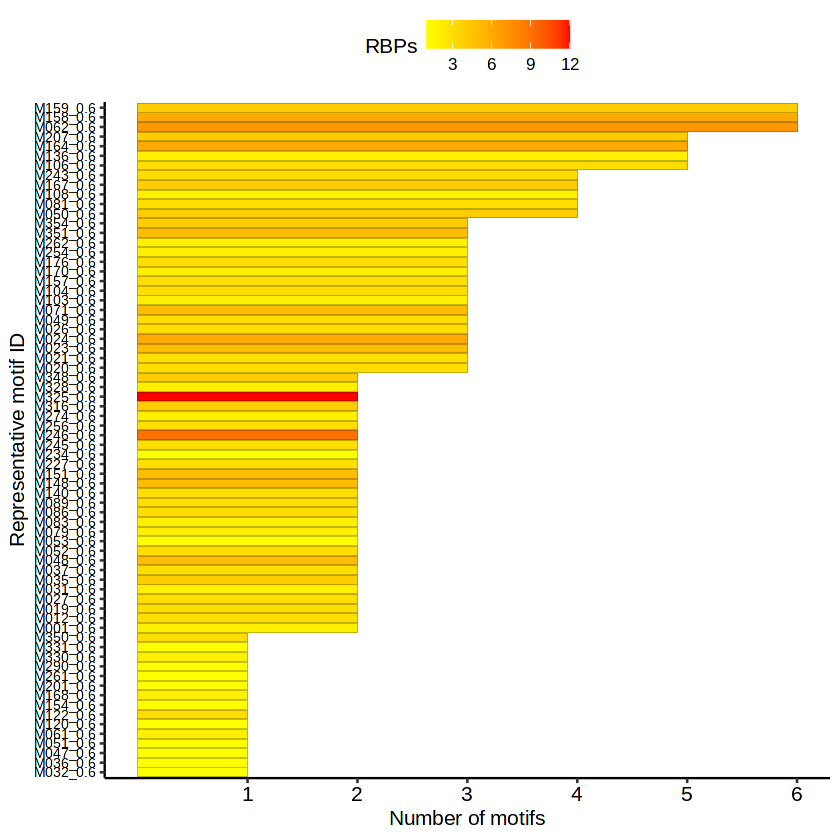

In [11]:
clust.rb.num<-clust.info %>%
            group_by(representative_motif) %>%
            summarize(nrbp=length(unique(RBP_Name)))

g<-motif.clusters %>%
    group_by(representative_motif) %>%
    summarize(size=length(cluster_num)) %>%
    arrange(size) %>%
    left_join(.,clust.rb.num) %>%
    mutate(representative_motif=factor(representative_motif,levels=representative_motif)) %>%
    ggplot(.,aes(y=representative_motif,x=size,fill=nrbp))+
        geom_bar(stat="identity",color="black",linewidth=0.05)+
        scale_x_continuous(breaks=1:6)+
        theme_pubr()+
        scale_fill_gradient(low = "yellow",high = "red")+
        labs(x="Number of motifs",y="Representative motif ID",fill="RBPs")+
        theme(axis.text.y = element_text(size=8,color="black"))
g

### Write results

In [12]:
clust.info.table<-clust.info %>%
                    group_by(cluster_num,representative_motif) %>%
                    summarize(motifs = paste(unique(Motif_ID),collapse = ", "),
                              RBPs = paste(unique(RBP_Name),collapse = ", "),
                              families = paste(unique(Family_Name),collapse = ", "))

`summarise()` has grouped output by 'cluster_num'. You can override using the
`.groups` argument.


In [14]:
write.table(motif.clusters,"../output/motif_clustering/25112023_all_motifs_clustered.tsv",row.names = F,col.names = T,sep="\t")

In [15]:
write.table(clust.info.table,
            row.names = FALSE,
            quote=FALSE,
            col.names = TRUE,
            sep="\t",
            file = "../output/motif_clustering/rbp_clustering_results.tsv")

In [16]:
out<-motif.clusters %>%
     distinct(motif,representative_motif) 
write.table(out,"../output/motif_clustering/25112023_representative_cluster_motifs.tsv",row.names = F,col.names = T,quote=FALSE,sep="\t")